Знакомство с синтаксисом и паттернами проектирования PyMC

2.1.1.  Связи «предок — потомок»

In [1]:
import pymc as pm
lambda_ = pm.Exponential("poisson_param", 1)
# Используется при обращении к следующей переменной...
data_generator = pm.Poisson("data_generator", lambda_)
data_plus_one = data_generator + 1

In [3]:
lambda_ , data_generator, data_plus_one

(<pymc.distributions.new_dist_class.<locals>.new_class 'poisson_param' at 0x0000000004E46640>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'data_generator' at 0x0000000004E466A0>,
 <pymc.PyMCObjects.Deterministic '(data_generator_add_1)' at 0x0000000004E46730>)

In [5]:
print ("Потомки 'lambda_': ")
print (lambda_.children)
print ("\nПредки 'data_generator': ")
print (data_generator.parents)
print ("\nПотомки 'data_generator': ")
print (data_generator.children)

Потомки 'lambda_': 
{<pymc.distributions.new_dist_class.<locals>.new_class 'data_generator' at 0x0000000004E466A0>}

Предки 'data_generator': 
{'mu': <pymc.distributions.new_dist_class.<locals>.new_class 'poisson_param' at 0x0000000004E46640>}

Потомки 'data_generator': 
{<pymc.PyMCObjects.Deterministic '(data_generator_add_1)' at 0x0000000004E46730>}


2.1.2.  Переменные PyMC

In [6]:
print ("lambda_.value =", lambda_.value)
print ("data_generator.value =", data_generator.value)
print ("data_plus_one.value =", data_plus_one.value)

lambda_.value = 1.6565571036888975
data_generator.value = 1
data_plus_one.value = 2


Инициализация стохастических переменных

In [13]:
some_variable = pm.DiscreteUniform("discrete_uni_var",0,4)

In [10]:
some_variable.value

array(3)

In [22]:
betas = pm.DiscreteUniform("betas", 0, 10, size=10)

In [23]:
betas

<pymc.distributions.new_dist_class.<locals>.new_class 'betas' at 0x000000000C563FD0>

In [24]:
betas.value

array([ 5, 10,  5,  0,  3,  7,  9,  4,  3,  2])

In [25]:
betas.value[4]

3

Вызов метода random()

In [2]:
lambda_1 = pm.Exponential('lambda_1',1) # априорное распределение для первого варианта поведения
lambda_2 = pm.Exponential("lambda_2", 1) # априорное распределение для второго варианта поведения
tau = pm.DiscreteUniform("tau", lower=0, upper=10)  # априорное распределение при смене поведения
print ("Инициализированные значения...")
print ("lambda_1.value: %.3f" % lambda_1.value)
print ("lambda_2.value: %.3f" % lambda_2.value)
print ("tau.value: %.3f" % tau.value)
print (lambda_1.random(), lambda_2.random(), tau.random())
print ("После вызова метода random() для этих переменных...")
print ("lambda_1.value: %.3f" % lambda_1.value)
print ("lambda_2.value: %.3f" % lambda_2.value)
print ("tau.value: %.3f" % tau.value)

Инициализированные значения...
lambda_1.value: 1.844
lambda_2.value: 0.305
tau.value: 5.000
0.6838229599489438 0.3388510957498572 0
После вызова метода random() для этих переменных...
lambda_1.value: 0.684
lambda_2.value: 0.339
tau.value: 0.000


In [41]:
samples = [lambda_1.random() for i in range(20)]
samples[2]

array(0.98218924)

In [42]:
float(samples[2])

0.9821892353914539

In [43]:
max(samples)

array(2.24047657)

Детерминистические переменные

In [28]:
type(lambda_1 + lambda_2)

pymc.PyMCObjects.Deterministic

In [29]:
import numpy as np
n_data_points = 5 # в главе 1 было ˜70 точек данных

@pm.deterministic
def lambda_(tau=tau, lambda_1=lambda_1, lambda_2=lambda_2):
    out = np.zeros(n_data_points)
    out[:tau] = lambda_1 # lambda до точки tau равна 1
    out[tau:] = lambda_2 # lambda после точки tau равна 2
    return out

In [38]:
@pm.deterministic
def some_deterministic(stoch=some_variable):
    return stoch**2

In [39]:
some_variable.value

array(1)

In [36]:
some_deterministic.value

1

2.1.3.  Учет наблюдений в модели

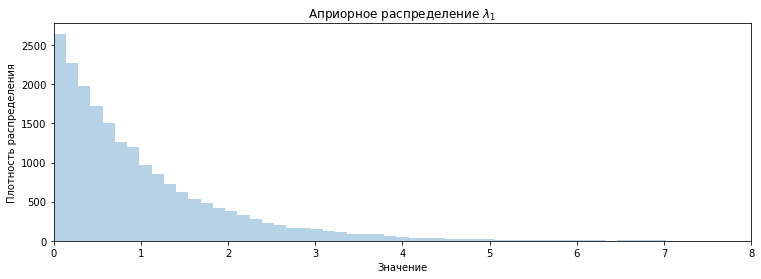

In [50]:
%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt

figsize(12.5,4)
#plt.rcParams['savefig.dpi'] = 300
#plt.rcParams['figure.dpi'] = 300
lambda_1 = pm.Exponential('lambda_1',1)

samples = [float(lambda_1.random()) for i in range(20000)]
plt.hist(samples, bins=70, alpha = 0.33)
plt.title("Априорное распределение $\lambda_1$")
plt.xlabel("Значение")
plt.ylabel("Плотность распределения")
plt.xlim(0, 8)
plt.show()

Наша следующая задача — учесть данные/факты/наблюдения X 
в нашей модели.

In [51]:
data = np.array([10, 5])
fixed_variable = pm.Poisson("fxd", 1, value=data, observed=True)
print ("значение: ", fixed_variable.value)
print ("вызываем .random()")
fixed_variable.random()
print ("значение: ", fixed_variable.value)

значение:  [10  5]
вызываем .random()
значение:  [10  5]


In [52]:
# Воспользуемся фиктивными данными
data = np.array([10, 25, 15, 20, 35])
obs = pm.Poisson("obs", lambda_, value=data, observed=True)#априорное распределение λ
print (obs.value)

[10 25 15 20 35]


2.1.4.   класс pm.Model

# 2.2.  Подходы к моделированию

2.2.1.  Та же история, но с другой концовкой

In [2]:
import pymc as pm

# 1. Указываем момент смены характера поведения пользователя 
# с помощью выборки из DiscreteUniform(0, 80).

tau = pm.rdiscrete_uniform(0, 80)
print (tau)

37


In [3]:
# 2.  Берем λ1 и λ2 из распределения Exp(α):
alpha = 1./20.
lambda_1, lambda_2 = pm.rexponential(alpha, 2)
print (lambda_1, lambda_2)

42.54196823133008 11.32036550015598


In [5]:
import numpy as np
# 3.  Для предшествующих τ дней λ = λ1; 
# для следующих за τ дней λ = λ2:
lambda_ = np.r_[lambda_1*np.ones(tau), lambda_2*np.ones(80-tau)]
print(lambda_)

[42.54196823 42.54196823 42.54196823 42.54196823 42.54196823 42.54196823
 42.54196823 42.54196823 42.54196823 42.54196823 42.54196823 42.54196823
 42.54196823 42.54196823 42.54196823 42.54196823 42.54196823 42.54196823
 42.54196823 42.54196823 42.54196823 42.54196823 42.54196823 42.54196823
 42.54196823 42.54196823 42.54196823 42.54196823 42.54196823 42.54196823
 42.54196823 42.54196823 42.54196823 42.54196823 42.54196823 42.54196823
 42.54196823 11.3203655  11.3203655  11.3203655  11.3203655  11.3203655
 11.3203655  11.3203655  11.3203655  11.3203655  11.3203655  11.3203655
 11.3203655  11.3203655  11.3203655  11.3203655  11.3203655  11.3203655
 11.3203655  11.3203655  11.3203655  11.3203655  11.3203655  11.3203655
 11.3203655  11.3203655  11.3203655  11.3203655  11.3203655  11.3203655
 11.3203655  11.3203655  11.3203655  11.3203655  11.3203655  11.3203655
 11.3203655  11.3203655  11.3203655  11.3203655  11.3203655  11.3203655
 11.3203655  11.3203655 ]


In [6]:
# 4.  Производим выборку из Poi(λ1)  для дней, предшествующих τ, и 
#Poi(λ2) для следующих за τ дней. Например:
data = pm.rpoisson(lambda_)
print (data)

[39 54 38 42 44 40 46 47 38 33 31 53 50 36 49 50 40 46 25 33 35 44 50 28
 41 40 49 49 61 46 57 44 40 40 48 41 56  9  6 12 10 18 14 13 10 11 16  9
 13  8 15 14  4  4 14 16 10 13 10 10 10  8 10  6  7  9  9 14 13 12 12 12
 14 15 11 14 18 11 13 10]


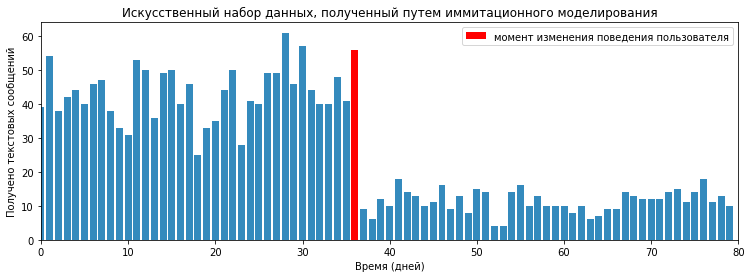

In [12]:
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
# 5. Строим график искусственно созданного набора данных
figsize(12.5,4)

plt.bar(np.arange(80), data, color="#348ABD")
plt.bar(tau-1, data[tau - 1], color="r", label=u"момент изменения поведения пользователя")
plt.xlabel("Время (дней)")
plt.ylabel("Получено текстовых сообщений")
plt.title("Искусственный набор данных, полученный путем иммитационного моделирования")
plt.xlim(0, 80)
plt.legend()
plt.show()

сгенерируем еще несколько наборов данных 

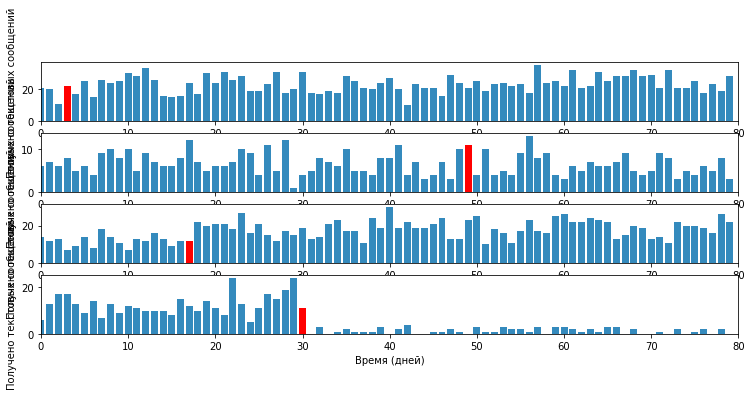

In [14]:
def plot_artifical_sms_dataset():
    tau = pm.rdiscrete_uniform(0, 80)
    alpha = 1./20.
    lambda_1, lambda_2 = pm.rexponential(alpha, 2)
    data = np.r_[pm.rpoisson(lambda_1, tau),pm.rpoisson(lambda_2, 80 - tau)]
    plt.bar(np.arange(80), data, color='#348ABD')
    plt.bar(tau - 1, data[tau - 1], color='r', label = 'изменение поведения пользователя')
    plt.xlim(0, 80)
    plt.xlabel('Время (дней)')
    plt.ylabel('Получено текстовых сообщений')
    
figsize(12.5, 5)
plt.title('Еще несколько искуственных датасетов, полученных в результате иммитационного моделирования')
for i in range(4):
    plt.subplot(4, 1, i+1)
    plt.xlabel('Время (дней)')
    plt.ylabel('Получено текстовых сообщений')
    plot_artifical_sms_dataset()

# Как на основе этого выполнять предсказания и проверять пригодность моделей

2.2.2.  Пример: байесовское A/B-тестирование

A/B-тестирование — статистический паттерн проектирования для определения различий эффективности двух разных методов лечения.

2.2.3.  Разберем пример с конверсией сайта

Вывод вероятных значений фактической частоты

In [15]:
# pA распределена равномерно по отрезку [0; 1]
import pymc as pm
# Параметры представляют собой границы равномерного распределения.
p = pm.Uniform('p', lower=0, upper=1)

In [33]:
# Задаем ограничения
p_true = 0.05 # Помните, что на практике это значение неизвестно
N = 1500 # сайт показан 1500 пользователям
# Выбираем N бернуллиевых случайных переменных из распределения Ber(0,05).
# Вероятность быть равной 1 для каждой из них составляет 0,05.
# Шаг генерации данных.
occurrences = pm.rbernoulli(p_true, N)
print (occurrences) # Помните: язык Python считает True == 1, а False == 0.
print (occurrences.sum())

[False False  True ... False False False]
80


In [34]:
# Occurrences.mean() равна n/N.
print ("Наблюдаемая частота в группе A = %.4f" % occurrences.mean())
print ("Равна ли наблюдаемая частота фактической? %s" % (occurrences.mean() == p_true))

Наблюдаемая частота в группе A = 0.0533
Равна ли наблюдаемая частота фактической? False


In [35]:
# Учитываем данные, распределенные по закону Бернулли.
obs = pm.Bernoulli("obs", p, value=occurrences, observed=True)

# Будет объяснено в главе 3
mcmc = pm.MCMC([p, obs])
mcmc.sample(20000, 1000)

 [-----------------100%-----------------] 20000 of 20000 complete in 6.4 sec

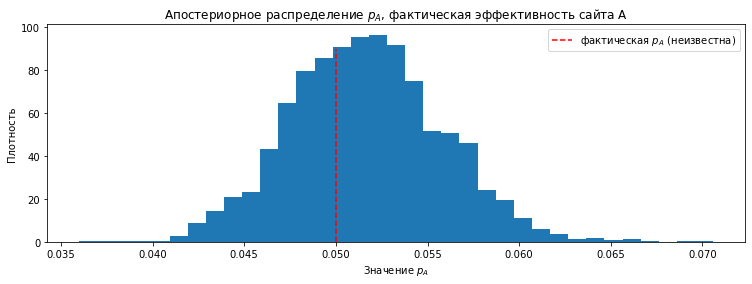

In [40]:
figsize(12.5, 4)
plt.title("Апостериорное распределение $p_A$, фактическая эффективность сайта A")
plt.vlines(p_true, 0, 90, linestyle="--", label=u"фактическая $p_A$ (неизвестна)", color ='r')
plt.hist(mcmc.trace("p")[:], bins=35, density=True, histtype="stepfilled")
plt.xlabel("Значение $p_A$")
plt.ylabel("Плотность")
plt.legend()
plt.show()

2.2.4.  A и B вместе

In [41]:
import pymc as pm
figsize(12, 4)
# Эти две величины нам неизвестны.
true_p_A = 0.05
true_p_B = 0.04
# Обратите внимание, что неодинаковые размеры выборок не доставляют
# никаких сложностей при байесовском анализе.
N_A = 1500
N_B = 750
# Генерируем наблюдения.
observations_A = pm.rbernoulli(true_p_A, N_A)
observations_B = pm.rbernoulli(true_p_B, N_B)
print ("Наблюдения с сайта A: ", observations_A[:30].astype(int), "...")
print ("Наблюдения с сайта B: ", observations_B[:30].astype(int), "...")

Наблюдения с сайта A:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] ...
Наблюдения с сайта B:  [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0] ...


In [42]:
print (observations_A.mean())
print (observations_B.mean())

0.046
0.04133333333333333


Создаем модель PyMC.

In [43]:
#  Опять предполагаем, что априорные
# распределения p_A и p_B — равномерные.
p_A = pm.Uniform('p_A', 0, 1)
p_B = pm.Uniform('p_B', 0, 1)

# Описываем детерминистическую функцию delta. Это и есть интересующая нас
# неизвестная величина.
@pm.deterministic
def delta(p_A = p_A, p_B = p_B):
    return p_A - p_B

# Набор данных наблюдений; в этом случае у нас два набора данных наблюдений.
obs_A = pm.Bernoulli("obs_A", p_A, value=observations_A, observed=True)
obs_B = pm.Bernoulli("obs_B", p_B, value=observations_B, observed=True)

# будет объяснено в главе 3
mcmc = pm.MCMC([p_A, p_B, delta, obs_A, obs_B])
mcmc.sample(25000, 5000)

 [-----------------100%-----------------] 25000 of 25000 complete in 7.4 sec

Графики апостериорных распределений для трех неизвестных

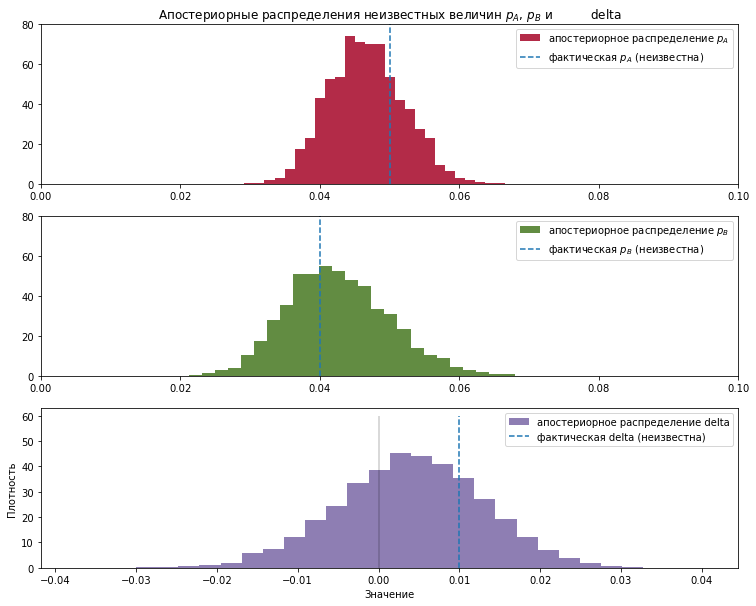

In [45]:
p_A_samples = mcmc.trace("p_A")[:]
p_B_samples = mcmc.trace("p_B")[:]
delta_samples = mcmc.trace("delta")[:]
figsize(12.5, 10)
# Гистограмма апостериорных распределений
ax = plt.subplot(311)
plt.xlim(0, .1)
plt.hist(p_A_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="апостериорное распределение $p_A$", color="#A60628",
         density=True)
plt.vlines(true_p_A, 0, 80, linestyle="--",
           label="фактическая $p_A$ (неизвестна)")
plt.legend(loc="upper right")
plt.title("Апостериорные распределения неизвестных величин $p_A$, $p_B$ и\
          delta")
plt.ylim(0,80)
ax = plt.subplot(312)
plt.xlim(0, .1)
plt.hist(p_B_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="апостериорное распределение $p_B$", color="#467821",
         density=True)
plt.vlines(true_p_B, 0, 80, linestyle="--",
           label="фактическая $p_B$ (неизвестна)")
plt.legend(loc="upper right")
plt.ylim(0,80)
ax = plt.subplot(313)
plt.hist(delta_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="апостериорное распределение delta", color="#7A68A6",
         density=True)
plt.vlines(true_p_A - true_p_B, 0, 60, linestyle="--",
           label="фактическая delta (неизвестна)")
plt.vlines(0, 0, 60, color="black", alpha=0.2)
plt.xlabel("Значение")
plt.ylabel("Плотность")
plt.legend(loc="upper right")


(0.0, 80.0)

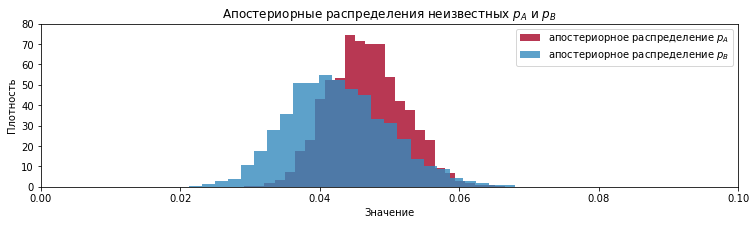

In [50]:
figsize(12.5, 3)
# Гистограмма апостериорных распределений
plt.xlim(0, .1)
plt.hist(p_A_samples, histtype='stepfilled', bins=30, alpha=0.80,
         label=u"апостериорное распределение $p_A$", color="#A60628",
         density=True)
plt.hist(p_B_samples, histtype='stepfilled', bins=30, alpha=0.80,
         label=u"апостериорное распределение $p_B$", color="#348abd",
         density=True)
plt.legend(loc="upper right")
plt.xlabel(u"Значение")
plt.ylabel(u"Плотность")
plt.title("Апостериорные распределения неизвестных $p_A$ и $p_B$")
plt.ylim(0,80)

In [47]:
# Подсчитываем число выборок < 0, то есть площадь под кривой до 0,
# отражающую вероятность того, что сайт A хуже сайта B.
print ("Вероятность того, что сайт A ХУЖЕ сайта B: %.3f" % \
    (delta_samples < 0).mean())
print ("Вероятность того, что сайт A ЛУЧШЕ сайта B: %.3f" % \
    (delta_samples > 0).mean())

Вероятность того, что сайт A ХУЖЕ сайта B: 0.321
Вероятность того, что сайт A ЛУЧШЕ сайта B: 0.679


In [49]:
delta_samples < 0

array([ True, False, False, ...,  True,  True, False])